# Approach 1: Generating Novel Music With Deep Convolutional Generative Adversarial   Network (DCGAN)

## Generating Muisc From Piano Music File.

1. This method corresponds to Approach 1 in our paper for generating sound from DCGAN.
2. The Music file used for this approach is piano music data file (sample_music.wav). 
3. In this process we are sampling the paino music file into samples of 1 second each and storing each seconds data as a greyscale png image. Since the file is stored at 44100 Hz per second. The size of the image will be 210 x 210.
4. In this process we are training the DCGAN with images of one second at one time. We are training the DCGAN 4 times. 
5. The first time is training the DCGAN with image and image copies of the image generated from the first second of piano data, second time is training the DCGAn with image and image copies of the image generated from the 2nd second of piano data, third time is training the DCGAn with image and image copies of the image generated from the 3rd second of piano data, fourth time is training the DCGAn with image and image copies of the image generated from the 4th second of piano data.

6. For each separate training the DCGAN will produce images similar to the images of the second of sound clip it is trined on. We will conactenate the sound recovered from these 4 training images to respoduce a sound clip which is similar to the first 4 seconds of the sample_music.wav file.

7. Following describes the process used in converting the sample_music.wav file into greyscale images, training a DCGAN eachtime separately with the images of a single second and recovering the sound back from the images generated by the generator in two different ways. 

### (Please note: The process of training the DCGAN is done through a separate python program and is not done in this python notebook. This notebook will expalin the steps to follow to train the DCGAN outside this python notebook).

In [2]:
#Importing the necessary packages
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as a
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
import pylab
import tensorflow as tf
import scipy.misc as mi
from PIL import Image 

In [3]:
# Most of the Spectrograms and Inversion are taken from: https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
# This function is used to pass the sound data through a filter to limit the low and the high frequency.

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))
    print ('X is', X)

    #ws = window_size
    #ss = window_step
    ws = window_size
    ss = int(window_step)
    a = X
    #print('window_step: ',window_step)
    #print('window_size: ',window_size)

    valid = len(a) - ws
    nw = int((valid) // ss)
    #print(nw)
    #print('Nw is', nw)
    out = np.ndarray((nw,ws),dtype = a.dtype)

    #for i in xrange(nw):
    for i in range(nw):
        # "slide" the window along the samples
        start = i * ss
        #print('Start is', start)
        stop = start + ws
        #print ('stop is', stop)
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram

# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log = True, fft_size = 512, step_size = 512/4, n_iter = 10):
    
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    step=int(step)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        
        wave = wave.astype('float64')
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset

def make_mel(spectrogram, mel_filter, shorten_factor = 1):
    mel_spec =np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(mel_spec.astype('float32'), [1, 1./shorten_factor]).astype('float16')
    mel_spec = mel_spec[:,1:-1] # a little hacky but seemingly needed for clipping 
    return mel_spec

def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    """
    takes in an mel spectrogram and returns a normal spectrogram for inversion 
    """
    mel_spec = (mel_spec+spec_thresh)
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(uncompressed_spec.astype('float32'), [1,shorten_factor]).astype('float16')
    uncompressed_spec = uncompressed_spec -4
    return uncompressed_spec

In [4]:
### Parameters ###
fft_size = 2048 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64 # number of mel frequency channels
shorten_factor = 10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from 

In [5]:
# Reading the Music file. Grab your wav and filter it
mywav = 'piano/music_sample.wav'
# Reading the data and the frequency rate.
rate, data = wavfile.read(mywav)
print('Rate:', rate)
#####################################################################################
# Finding the number of seconds in the data file
seconds = int(data[:,1].shape[0]/rate)
print('Total Seconds:', seconds)
# Passing the data through a band pass filter to filter the low cut and high cut frequencies. The lowcut frequency is 
# set at 500 Hz and the high cut is set at 15000 Hz
data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
# Only use a short clip for our demo
# Clip the data into 20 seconds.
if np.shape(data)[0]/float(rate) > 20:
    data = data[0:rate*20] 
print ('Length in time (s): ', np.shape(data)[0]/float(rate))
# Extracting the frequency data from the music data. This is the data we are going to save into images.
data=data[:,1]

C:\Users\Shreyas\Anaconda3\envs\tf\lib\site-packages\scipy\io\wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Rate: 44100
Total Seconds: 21
Length in time (s):  20.0


## Saving the Images
1. Images of each second are saved in the 'piano' folder with name grey%*%.png. 


In [7]:
# Finding the minimim and maximum of the data.
vmin=data.min() 
vmax=data.max()
norm = plt.Normalize(vmin=data.min(), vmax=data.max())
# Spilting the data into 20 samples each of one second
samples=np.array_split(data, seconds-1)
i=0
#Generating Greyscale Images for Each Second and saving them as grey + i.png
for x in samples:
    i=i+1
    filename='piano/grey'+str(i)+'.png'
    img=mi.toimage(x.reshape(210,210), cmin=x.min(), cmax=x.max())
    #The commented code below to scale with min and max frequency of the whole sound file. This is not necessary in this approach
    #as we are training separately on for image generated for each second of music.
    #img=mi.toimage(x.reshape(210,210), cmin=vmin, cmax=vmax)
    img.save(filename)
    #unscaled = np.reshape(img, (1,np.product([210,210])))
    #reshaped=unscaled.reshape(44100)
    #print(reshaped)
print('Sample Music:')
# Playing the sample music of 20 seconds
IPython.display.Audio(data=data, rate=rate)

Sample Music:


In [8]:
# Playing the first second of sample music.
print('first second of sample music')
IPython.display.Audio(data=samples[0], rate=rate)

first second of sample music


In [9]:
# Playing the 2nd second of sample music
print('2nd second of sample music')
IPython.display.Audio(data=samples[1], rate=rate)

2nd second of sample music


In [10]:
# # Playing the 3rd second of sample music
print('Sample Music third second')
IPython.display.Audio(data=samples[2], rate=rate)

Sample Music third second


In [11]:
# Playing the 4th second of sample music
print('Sample Music 4th second')
IPython.display.Audio(data=samples[3], rate=rate)

Sample Music 4th second


## Training our DCGAN with the Sound Image Generated from the first second of Sample_Music.wav

1. Once the images are saved in the 'piano' folder. The images have to be convered into a Tfrecords file. To convert the images into Tfrecords we use the code present in 'create_tfrecords' folder.

## Follow the below steps to convert the greyscale images into .tfrecords files.

1. Create a foler called 'Piano' in 'create_tfrecords' folder. Inside this folder create another folder called 'paino_data'.
2. Inside this 'piano_data' folde  create another folder called 'piano1'.
3. Copy the image grey1.png present in 'piano/' folder and paste it in the 'create_tfrecords\piano\piano_data\piano1' folder. Create 20 copies of the grey1.png image in the 'create_tfrecords\piano\piano_data\piano1' folder.
4. In your python termial run the file create_tfrecord.py present in 'create_tfrecords' folder by typing the following command.
   ##### python create_tfrecord.py --dataset_dir=paino/ --tfrecord_filename=pianosame
5. The above command will create 4 Tfrecord files. two for training and two validation files in the folder 'create_tfrecords/piano'. As the number of shards defined in the create_tfrecord.py is 2, the program creates two pairs of tfrecord files.

## Training Our DCGAN using the TfRecord files generated.

1. Copy the 4 Tfrecord files into the 'SoundDCGAN/Data' folder.
2. Open the Train.py file and in the main function make sure s_size=13 for following code: DCGAN(s_size=13). This will make the generator output images of size 208 x 208
3. Go to the path of 'SoundDCGAN' folder and run the following command 
   ##### python train.py
4. This will start training the DCGAN on the data present in the Tfrecord files.
5. 'Logdir' folder inside the 'SoundDCGAN' folder will store the generator and the discriminator checkpoints after every 500 iterations. If the model has already been trained then the model will be restored from the previous check points and continue training from that point.
6. The images generated by the generator are stored in the 'SoundDCGAN/Images' folder. The images are saved in this for every 100 iterations of the training.
7. Copy these images and save them in the 'piano/sound1same/' folder from where the following code is used to convert the image into back into sound.


In [12]:
img1 = mi.imread('piano/sound1same/09200.png')
unscaled1 = np.reshape(img1, (1,np.product([208,208])))
reshaped1=unscaled1.reshape(43264)
print(reshaped1)

wav_spectrogram1 = pretty_spectrogram(reshaped1.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
print('Generated audio for 1st second')
# Playing the sound generated for second 1
IPython.display.Audio(data=reshaped1, rate=rate)

[175 129 164 ..., 136 141 129]
X is [ 45.6378051  -0.3621949  34.6378051 ...,   0.          0.          0.       ]
Generated audio for 1st second


In [13]:
# Saving Sound generated from image for second 1
scipy.io.wavfile.write('piano/sound1same/second1_recovered.wav', 44100, reshaped1)

## Training our DCGAN with the Sound Image Generated from the 2nd second of Sample_Music.wav

1. Once the images are saved in the 'piano' folder. The images have to be convered into a Tfrecords file. To convert the images into Tfrecords we use the code present in 'create_tfrecords' folder.

## Follow the below steps to convert the greyscale images into .tfrecords files.

1. Create a foler called 'Piano2' in 'create_tfrecords' folder. Inside this folder create another folder called 'paino_data'.
2. Inside this 'piano_data' folde  create another folder called 'piano2'.
3. Copy the image grey2.png present in 'piano/' folder and paste it in the 'create_tfrecords\piano2\piano_data\piano2' folder. Create 20 copies of the grey2.png image in the 'create_tfrecords\piano2\piano_data\piano2' folder.
4. In your python termial run the file create_tfrecord.py present in 'create_tfrecords' folder  typing the following command.
   ##### python create_tfrecord.py --dataset_dir=paino2/ --tfrecord_filename=piano2
5. The above command will create 4 Tfrecord files. two for training and two validation files in the folder 'create_tfrecords/piano2'. As the number of shards defined in the create_tfrecord.py is 2, the program creates two pairs of tfrecord files.

## Training Our DCGAN using the TfRecord files generated.

1. Copy the 4 Tfrecord files into the 'SoundDCGAN/Data' folder.
2. Open the Train.py file and in the main function make sure s_size=13 for following code: DCGAN(s_size=13). This will make the generator output images of size 208 x 208
3. Go to the path of 'SoundDCGAN' folder and run the following command 
   ##### python train.py
4. This will start training the DCGAN on the data present in the Tfrecord files.
5. 'Logdir' folder inside the 'SoundDCGAN' folder will store the generator and the discriminator checkpoints after every 500 iterations. If the model has already been trained then the model will be restored from the previous check points and continue training from that point.
6. The images generated by the generator are stored in the 'SoundDCGAN/Images' folder. The images are saved in this for every 100 iterations of the training.
7. Copy these images and save them in the 'piano/sound2same/' folder from where the following code is used to convert the image into back into sound.

In [14]:
img2 = mi.imread('piano/sound2same/07700.png')
unscaled2 = np.reshape(img2, (1,np.product([208,208])))
reshaped2=unscaled2.reshape(43264)
wav_spectrogram2 = pretty_spectrogram(reshaped2.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)

print('Generated audio for 2nd second')
# Playing the sound generated for second 2
IPython.display.Audio(data=reshaped2, rate=rate)

X is [-29.73876664  15.26123336  35.26123336 ...,   0.           0.           0.        ]
Generated audio for 2nd second


In [15]:
# Saving Sound generated from image for second 2
scipy.io.wavfile.write('piano/sound2same/second2_recovered.wav', 44100, reshaped2)

## Training our DCGAN with the Sound Image Generated from the 3rd second of Sample_Music.wav

1. Once the images are saved in the 'piano' folder. The images have to be convered into a Tfrecords file. To convert the images into Tfrecords we use the code present in 'create_tfrecords' folder.

## Follow the below steps to convert the greyscale images into .tfrecords files.

1. Create a foler called 'Piano3' in 'create_tfrecords' folder. Inside this folder create another folder called 'paino_data'.
2. Inside this 'piano_data' folde  create another folder called 'piano3'.
3. Copy the image grey3.png present in 'piano/' folder and paste it in the 'create_tfrecords\piano3\piano_data\piano3' folder. Create 20 copies of the grey3.png image in the 'create_tfrecords\piano2\piano_data\piano3' folder.
4. In your python termial run the file create_tfrecord.py present in 'create_tfrecords' folder by typing the following command.
   ##### python create_tfrecord.py --dataset_dir=paino3/ --tfrecord_filename=piano3
5. The above command will create 4 Tfrecord files. two for training and two validation files in the folder 'create_tfrecords/piano3'. As the number of shards defined in the create_tfrecord.py is 2, the program creates two pairs of tfrecord files.

## Training Our DCGAN using the TfRecord files generated.

1. Copy the 4 Tfrecord files into the 'SoundDCGAN/Data' folder.
2. Open the Train.py file and in the main function make sure s_size=13 for following code: DCGAN(s_size=13). This will make the generator output images of size 208 x 208
3. Go to the path of 'SoundDCGAN' folder and run the following command 
   ##### python train.py
4. This will start training the DCGAN on the data present in the Tfrecord files.
5. 'Logdir' folder inside the 'SoundDCGAN' folder will store the generator and the discriminator checkpoints after every 500 iterations. If the model has already been trained then the model will be restored from the previous check points and continue training from that point.
6. The images generated by the generator are stored in the 'SoundDCGAN/Images' folder. The images are saved in this for every 100 iterations of the training.
7. Copy these images and save them in the 'piano/sound3same/' folder from where the following code is used to convert the image into back into sound.

In [16]:
img3 = mi.imread('piano/sound3same/09000.png')
unscaled3 = np.reshape(img3, (1,np.product([208,208])))
reshaped3=unscaled3.reshape(43264)

wav_spectrogram3 = pretty_spectrogram(reshaped3.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
print('Generated audio for 3rd second')
# Playing the sound generated from image 3.
IPython.display.Audio(data=reshaped3, rate=rate)

X is [-4.06139053 -9.06139053 -8.06139053 ...,  0.          0.          0.        ]
Generated audio for 3rd second


In [17]:
# Saving Sound generated from image for second 3
scipy.io.wavfile.write('piano/sound3same/second3_recovered.wav', 44100, reshaped3)

## Training our DCGAN with the Sound Image Generated from the 3rd second of Sample_Music.wav

1. Once the images are saved in the 'piano' folder. The images have to be convered into a Tfrecords file. To convert the images into Tfrecords we use the code present in 'create_tfrecords' folder.

## Follow the below steps to convert the greyscale images into .tfrecords files.

1. Create a foler called 'Piano4' in 'create_tfrecords' folder. Inside this folder create another folder called 'paino_data'.
2. Inside this 'piano_data' folder  create another folder called 'piano4'.
3. Copy the image grey4.png present in 'piano/' folder and paste it in the 'create_tfrecords\piano4\piano_data\piano4' folder. Create 20 copies of the grey4.png image in the 'create_tfrecords\piano4\piano_data\piano4' folder.
4. In your python termial run the file create_tfrecord.py present in 'create_tfrecords' folder by typing the following command.
   ##### python create_tfrecord.py --dataset_dir=paino4/ --tfrecord_filename=piano4
5. The above command will create 4 Tfrecord files. two for training and two validation files in the folder 'create_tfrecords/piano3'. As the number of shards defined in the create_tfrecord.py is 2, the program creates two pairs of tfrecord files.

## Training Our DCGAN using the TfRecord files generated.

1. Copy the 4 Tfrecord files into the 'SoundDCGAN/Data' folder.
2. Open the Train.py file and in the main function make sure s_size=13 for following code: DCGAN(s_size=13). This will make the generator output images of size 208 x 208
3. Go to the pathof 'SoundDCGAN' folder and run the following command 
   ##### python train.py
4. This will start training the DCGAN on the data present in the Tfrecord files.
5. 'Logdir' folder inside the 'SoundDCGAN' folder will store the generator and the discriminator checkpoints after every 500 iterations. If the model has already been trained then the model will be restored from the previous check points and continue training from that point.
6. The images generated by the generator are stored in the 'SoundDCGAN/Images' folder. The images are saved in this for every 100 iterations of the training.
7. Copy these images and save them in the 'piano/sound4same/' folder from where the following code is used to convert the image into back into sound.

In [18]:
img4 = mi.imread('piano/sound4same/00350.png')
unscaled4 = np.reshape(img4, (1,np.product([208,208])))
reshaped4=unscaled4.reshape(43264)

wav_spectrogram4 = pretty_spectrogram(reshaped4.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
print('Generated audio for 4th second')
IPython.display.Audio(data=reshaped4, rate=rate)


X is [  6.77514793  15.77514793  33.77514793 ...,   0.           0.           0.        ]
Generated audio for 4th second


In [19]:
# Saving Sound generated from image for second 4
scipy.io.wavfile.write('piano/sound4same/second4_recovered.wav', 44100, reshaped4)

In [20]:
## Combining the Sound Recovered from 4 Images

In [21]:
app=np.concatenate((reshaped1,reshaped2))
app=np.concatenate((app,reshaped3))
app=np.concatenate((app,reshaped4))
print('Generated Audio Combined for 4 seconds.')
# Playing the combined sound.
IPython.display.Audio(data=app, rate=rate)

Generated Audio Combined for 4 seconds.


In [22]:
# Saving the combined sound.
scipy.io.wavfile.write('piano/recovered_sound.wav', 44100, app)

 ## Another Way of Recovering the sound from image.
1. Another way of recovering sound from the image is to to convert image into spectrogram which has frequencies on the y axis and time on x axis. Since the image data represents frequencies we convert the data from the image into a spectrogram and the recover the sound from the spectrogram. This is just another way of recovering sound to see if there is any improvment in reducing noise from the recovered sound

fig is Figure(72x72)
Generated Spectrogram from GAN generated Sound Second 1


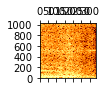

In [23]:
# Plotting the spectrogram from image 1
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(1,1))
print('fig is', fig)
cax = ax.matshow(np.transpose(wav_spectrogram1), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
print('Generated Spectrogram from GAN generated Sound Second 1')
# Saving the spectrogram.
fig.savefig('piano/Spec1.png') # Use fig. here

fig is Figure(72x72)
Generated Spectrogram from GAN generated Sound Second 2


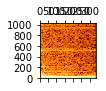

In [24]:
# Plotting the spectrogram from image 2
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(1,1))
print('fig is', fig)

cax = ax.matshow(np.transpose(wav_spectrogram2), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
print('Generated Spectrogram from GAN generated Sound Second 2')
# Saving the spectrogram
fig.savefig('piano/Spec2.png') # Use fig. here

fig is Figure(72x72)
Generated Spectrogram from GAN generated Sound Second 3


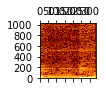

In [25]:
# Plotting the spectrogram from image 3
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(1,1))
print('fig is', fig)
cax = ax.matshow(np.transpose(wav_spectrogram3), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
print('Generated Spectrogram from GAN generated Sound Second 3')
# Saving the spectrogram
fig.savefig('piano/Spec3.png') # Use fig. here

fig is Figure(72x72)
Generated Spectrogram from GAN generated Sound Second 4


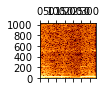

In [26]:
# Plotting the spectrogram from image 4
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(1,1))
print('fig is', fig)
cax = ax.matshow(np.transpose(wav_spectrogram4), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
print('Generated Spectrogram from GAN generated Sound Second 4')
# Saving the spectrogram.
fig.savefig('piano/Spec4.png') # Use fig. here

In [31]:
# Recovering the audio from the spectrogram generated from image 1
recovered_audio_orig1 = invert_pretty_spectrogram(wav_spectrogram1, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
print('Recoveded Audio from spectrogram of first second generated by GAN')
IPython.display.Audio(data=recovered_audio_orig1, rate=rate) # play the audio

X is [-0.00072818 -0.00043324 -0.00034237 ...,  0.          0.          0.        ]
X is [ 0.00155194  0.00104989  0.00170661 ...,  0.          0.          0.        ]
X is [-0.00037343 -0.00042018 -0.00067132 ...,  0.          0.          0.        ]
X is [ 0.00102692  0.00091878  0.00056897 ...,  0.          0.          0.        ]
X is [ 0.00174569  0.00140724  0.00174702 ...,  0.          0.          0.        ]
X is [-0.00042929  0.00031317 -0.00042781 ...,  0.          0.          0.        ]
X is [-0.00160936 -0.00124868 -0.00040305 ...,  0.          0.          0.        ]
X is [ 0.00094853  0.00026954  0.00072325 ...,  0.          0.          0.        ]
X is [ -3.84720772e-05   3.33022756e-04   1.94298530e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.00028252  0.00078967  0.00160734 ...,  0.          0.          0.        ]
Recoveded Audio from spectrogram of first second generated by GAN


In [30]:
# Recovering the audio from the spectrogram generated from image 2
recovered_audio_orig2 = invert_pretty_spectrogram(wav_spectrogram2, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
print('Recoveded Audio from spectrogram of 2nd second generated by GAN')
IPython.display.Audio(data=recovered_audio_orig2, rate=rate) # play the audio

X is [  2.61230056e-05  -6.79552112e-04  -3.35541409e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.00237538  0.00306514  0.0023984  ...,  0.          0.          0.        ]
X is [ 0.00029394  0.00015106 -0.00036417 ...,  0.          0.          0.        ]
X is [ 0.00135074  0.00064715  0.00127453 ...,  0.          0.          0.        ]
X is [-0.00113787 -0.00032049 -0.0008884  ...,  0.          0.          0.        ]
X is [ 0.00194875  0.00146452  0.00095269 ...,  0.          0.          0.        ]
X is [ -3.40608213e-04  -1.54224936e-03   8.99374617e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.00182789  0.00142406  0.00114958 ...,  0.          0.          0.        ]
X is [ -2.60632780e-04  -2.10970886e-06   6.95241637e-06 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.00195157  0.00161147  0.00159394 ...,  0.          0.          0.        ]
Recoveded Audio from spectrogram of 2nd second generated by GAN


In [28]:
# Recovering the audio from the spectrogram generated from image 3
recovered_audio_orig3 = invert_pretty_spectrogram(wav_spectrogram3, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
print('Recoveded Audio from spectrogram of 3rd second generated by GAN')
IPython.display.Audio(data=recovered_audio_orig3, rate=rate) # play the audio

X is [ -9.94891025e-05  -1.02406261e-04  -1.38266552e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.0002948   0.00029794  0.00034317 ...,  0.          0.          0.        ]
X is [-0.00010326 -0.00016424 -0.00014414 ...,  0.          0.          0.        ]
X is [ 0.00011051  0.00013426  0.00018039 ...,  0.          0.          0.        ]
X is [-0.00018495 -0.00020306 -0.00021823 ...,  0.          0.          0.        ]
X is [  1.16378366e-04   8.78912423e-05   8.51600212e-06 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ -1.67485789e-04  -9.96162528e-05  -1.63764370e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [  1.02794870e-04   9.28516417e-05   7.75409754e-06 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [-0.00024848 -0.00015582 -0.00027418 ...,  0.          0.          0.        ]
X is [ -5.34158125e-05  -8.16837368e-05  -3.16866545e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
Recov

In [29]:
# Recovering the audio from the spectrogram generated from image 4
recovered_audio_orig4 = invert_pretty_spectrogram(wav_spectrogram4, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)
print('Recoveded Audio from spectrogram of 4th second generated by GAN')
IPython.display.Audio(data=recovered_audio_orig4, rate=rate) # play the audio

X is [  7.21218192e-05   1.65171278e-04   3.22376568e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.00038042  0.00086023  0.0008109  ...,  0.          0.          0.        ]
X is [ -2.67875928e-04  -7.82055182e-04  -6.87497096e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.00023812  0.00025204 -0.00012999 ...,  0.          0.          0.        ]
X is [-0.00052078 -0.00085096 -0.00060667 ...,  0.          0.          0.        ]
X is [ 0.00131599  0.00146669  0.00110449 ...,  0.          0.          0.        ]
X is [-0.00080094 -0.00106941 -0.00117835 ...,  0.          0.          0.        ]
X is [ 0.00081422  0.00043267  0.00026422 ...,  0.          0.          0.        ]
X is [  8.45541107e-05   1.08664245e-04   6.67726804e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.0009087   0.00077281  0.0009207  ...,  0.          0.          0.        ]
Recoveded Audio from spectrogram of 4th second generated by GAN
